# **GradientBoostingRegressor**

*Fonctionne avec Python 3.10.9 (Anaconda 23.3.1), Lime 0.2.0.1 et Shap 0.42.1*

## **Importation des bibliothèques**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Pour les traîtements sur les variables
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Modèle de ML utilisé
from sklearn.ensemble import GradientBoostingRegressor

# Pour gridsearch
from sklearn import model_selection

# Pour mesures des metrics des résultats
from sklearn import metrics

# Pour mise en forme des résultats
import colorama

# Pour les explications locales
import lime
import lime.lime_tabular

# Pour les explications globale et locales
import shap


## **Importation du dataset**

In [2]:
dataset_a_utiliser = "data_clean.xlsx"

data = pd.read_excel(dataset_a_utiliser)

## **Fonctions**

In [3]:
def split_and_scale(dataset_name, y_column, features_list, numeric_features, categorical_features, stratification):

    ##############################
    # Split du dataset en X et y #
    ##############################

    global X
    global y

    X = data.loc[:,features_list] # On ajoute nos features dans le X
    y = data.loc[:,y_column] # On ajoute ce qu'on veut prédire dans le y

    ############################
    # Scaling et Encoding de X #
    ############################

    global feature_encoder

    # Ici nous avons de meilleurs résultats avec RobustScaler()
    numeric_transformer = StandardScaler()

    categorical_transformer = OneHotEncoder(sparse_output=False) # sparse_output=False pour éviter que OneHotEncoder() ne retourne une matrice creuse (sparse, scipy.sparse.csr_matrix)

    feature_encoder = ColumnTransformer(
                transformers=[
                    ('cat', categorical_transformer, categorical_features),    
                    ('num', numeric_transformer, numeric_features)
                    ]
                )
    X = feature_encoder.fit_transform(X)


    ####################################
    # Split de X et y en train et test #
    ####################################

    global X_train
    global X_test
    global y_train
    global y_test

    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=0.2, 
                                                        random_state=0,
                                                        stratify=eval(stratification))

## **Features**

In [4]:
######################
# Choix des features #
######################

dataset_name = data

# Si rien mettre []
categorical_features = [
                        'BuildingType',
                        'PrimaryPropertyType',
                        'Neighborhood',
                        'ZipCode',
                        'YearBuilt'
                       ]

# Si rien mettre []
numeric_features = [
                    'NumberofBuildings',
                    'NumberofFloors',
                    'PropertyGFAParking',
                    'PropertyGFABuilding(s)',
                    'Latitude',
                    'Longitude',
                    #'gas_prop',
                    #'elec_prop',
                    #'steam_prop',
                    'age_bat'
                   ]

# Toutes les features
features_list = categorical_features + numeric_features

## ***GradientBoostingRegressor***

In [5]:
# WN ou nom
EnergyUse = 'SiteEnergyUseWN_kBtu'
#EnergyUse = 'SiteEnergyUse(kBtu)'

# Targets à estimer
targets = [EnergyUse, 'TotalGHGEmissions']

# "y" pour stratifier y, sinon "None"
stratification = "None"

# Afficher les résultats détaillés (True/False)
details = False

for i in targets:

    y_column=i

    print(f"=========== [{i}] ===========")

    # Split & Scale du dataset
    split_and_scale(dataset_name, y_column, features_list, numeric_features, categorical_features, stratification)

    # Entraînement simple
    modele = GradientBoostingRegressor() # Paramètres par défaut
    modele.fit(X_train, y_train) # Étape d'entraînement
    print("--- Entraînement simple (paramètres par défaut): ---")
    y_pred = modele.predict(X_test)
    print(f"R² : {modele.score(X_train, y_train):.3f} (train) et {colorama.Style.BRIGHT}{colorama.Back.CYAN}{colorama.Fore.BLACK} {modele.score(X_test, y_test):.3f} {colorama.Style.RESET_ALL} (test)")
    print(f"RMSE : {metrics.mean_squared_error(y_test, y_pred)**0.5:.4}")
    print(f"MAE : {metrics.mean_absolute_error(y_test, y_pred):.4}")


    ###############################################
    # Paramétrage de GridSearchCV et entraînement #
    ###############################################

    print("--- GridSearch : ---")

    alphas = np.linspace(0.8, 0.87, 5)

    # Fixer les valeurs des hyperparamètres à tester
    param_grid = [
                  {'loss':['huber', 'quantile'], 'alpha':[0.8, 0.835], 'n_estimators':[200], 'learning_rate':[0.17]}
                  # 'huber', 'quantile' : ces deux donnent les meilleurs résultats
                  # n_estimators=200 (par défaut 100) : améliore un peu les scores, sans trop augmenter le temps
                  # learning_rate=0.17 : après essais, donne les meilleurs résultats
                  # alpha : 0.835 et 0.8 sont ceux qui donnent les meilleurs résultats
                 ]
    # learning_rate=0.001, n_estimators=100

    # Déterminer le score qu'on veut optimiser
    score = 'r2'

    # Je le sors ici car je vais réutiliser cette valeur plus tard
    cv = 5

    globals()[f"grid_{i}"] = model_selection.GridSearchCV(
        GradientBoostingRegressor(random_state=1000), # On indique le modèle à tester
        param_grid,     # hyperparamètres à tester
        cv=cv,           # nombre de folds de validation croisée
        scoring=score   # score à optimiser
    )

    # Optimiser ce modèle sur le jeu d'entraînement
    globals()[f"grid_{i}"].fit(X_train, y_train)


    ###########################
    # Affichage des résultats #
    ###########################

    # Afficher le(s) hyperparamètre(s) optimaux
    best_params = globals()[f"grid_{i}"].best_params_
    print(f"Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement : {best_params}")

    mean = globals()[f"grid_{i}"].cv_results_['mean_test_score'], # score moyen
    std = globals()[f"grid_{i}"].cv_results_['std_test_score'],  # écart-type du score

    print(f"Résultats de la validation croisée : {score} (moyen) : {colorama.Style.BRIGHT}{colorama.Back.YELLOW}{colorama.Fore.BLACK} {mean[0][0]:.03f} {colorama.Style.RESET_ALL} +/-({std[0][0]*2:.03f})")

    # Afficher les performances correspondantes
    if details == True:
        print('Résultats pour chaque fold :')
        for j in range(cv):
            params = globals()[f"grid_{i}"].cv_results_['params']
            print(f"Fold n°{j+1} :", eval(f"grid_{i}.cv_results_['split{j}_test_score']"), f"(Pour les paramètres : {params})")

        print("\nRésultats de la validation croisée :")
        for mean, std, params in zip(
                globals()[f"grid_{i}"].cv_results_['mean_test_score'], # score moyen
                globals()[f"grid_{i}"].cv_results_['std_test_score'],  # écart-type du score
                globals()[f"grid_{i}"].cv_results_['params']           # valeur de l'hyperparamètre
            ):

            print(f"{score} (moyen) : {mean:.04f} (+/-{std*2:.04f}) pour {params}")


    ###################################################################
    # Prédiction sur le jeu de test avec les hyperparamètres optimaux #
    ###################################################################

    # GridSearchCV a automatiquement ré-entraîné le meilleur modèle sur l’intégralité du jeu d’entraînement.
    y_pred = globals()[f"grid_{i}"].predict(X_test)
    print(f"--- Score sur le jeu de test (avec paramètres optimaux) --- ")
    print(f"R² : {colorama.Style.BRIGHT}{colorama.Back.GREEN}{colorama.Fore.BLACK} {metrics.r2_score(y_test, y_pred):.3f} {colorama.Style.RESET_ALL}")
    print(f"RMSE : {metrics.mean_squared_error(y_test, y_pred)**0.5:.4}")
    print(f"MAE : {metrics.mean_absolute_error(y_test, y_pred):.4}")

    print('_'*80, "\n")

    

=========== [SiteEnergyUseWN_kBtu] ===========
--- Entraînement simple (paramètres par défaut): ---
R² : 0.916 (train) et  0.657  (test)
RMSE : 5.94e+06
MAE : 3.272e+06
--- GridSearch : ---
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement : {'alpha': 0.8, 'learning_rate': 0.17, 'loss': 'huber', 'n_estimators': 200}
Résultats de la validation croisée : r2 (moyen) :  0.650  +/-(0.197)
--- Score sur le jeu de test (avec paramètres optimaux) --- 
R² :  0.756 
RMSE : 5.008e+06
MAE : 2.702e+06
________________________________________________________________________________ 

=========== [TotalGHGEmissions] ===========
--- Entraînement simple (paramètres par défaut): ---
R² : 0.922 (train) et  0.340  (test)
RMSE : 238.7
MAE : 112.0
--- GridSearch : ---
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement : {'alpha': 0.8, 'learning_rate': 0.17, 'loss': 'quantile', 'n_estimators': 200}
Résultats de la validation croisée : r2 (moyen) :  0.334  +/-(0.396)
--- Score sur le jeu de test (a

## **Importance locale des features avec LIME**

In [6]:
# Targets dont on veut expliquer les features
targets = [EnergyUse, 'TotalGHGEmissions']

# On choisit combien de features on veut expliquer
nb_features = 10

# On choisit quelle instance on veut tester (ça commence à 0)
instance_a_tester = 0

for i in targets:

    # chaque catégorie est représentée par tous les éléments qu'elle contient, donc je ne peux pas juste prendre features_list
    all_features = list(np.concatenate(feature_encoder.transformers_[0][1].categories_)) + numeric_features

    print(f"=========== [Importance relative locale avec LIME pour {i}] ===========")
    print(f"--- Instance n°{instance_a_tester+1} (nombre d'instances : {len(X_test)}) ---\n") # instance_a_tester+1 car dans le langage courrant on commence à compter à 1

    # Création de l'explainer
    explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=all_features,
                                                    class_names=[i], verbose=True, mode='regression')

    # Je reprends le même nom dynamique globals()[f"grid_{i}"] que celui utilisé pour définir
    # le nom des modèles de GridsearchCV créés précédemment
    exp = explainer.explain_instance(X_test[instance_a_tester], globals()[f"grid_{i}"].predict, num_features=nb_features)

    exp.show_in_notebook(show_table=True)

    print('_'*80, "\n")

=========== [Importance relative locale avec LIME pour SiteEnergyUseWN_kBtu] ===========
--- Instance n°1 (nombre d'instances : 303) ---

Intercept 126841460.28805435
Prediction_local [2553915.2777254]
Right: 1192793.0316189318


________________________________________________________________________________ 

=========== [Importance relative locale avec LIME pour TotalGHGEmissions] ===========
--- Instance n°1 (nombre d'instances : 303) ---

Intercept 1623.3011744490648
Prediction_local [52.48359086]
Right: 43.52518557479005


________________________________________________________________________________ 



## **Importance globale des features avec SHAP**

On va utiliser shap.TreeExplainer() qui est le mieux adapté pour cet algorithme.

In [7]:
# initialisation
shap.initjs()

# Je convertis tous les nom des features en STR (certain sont des int), pour éviter les soucis au moment des explications locale
all_features = [str(feature_name) for feature_name in all_features]

=========== [Importance globale des features pour SiteEnergyUseWN_kBtu] ===========


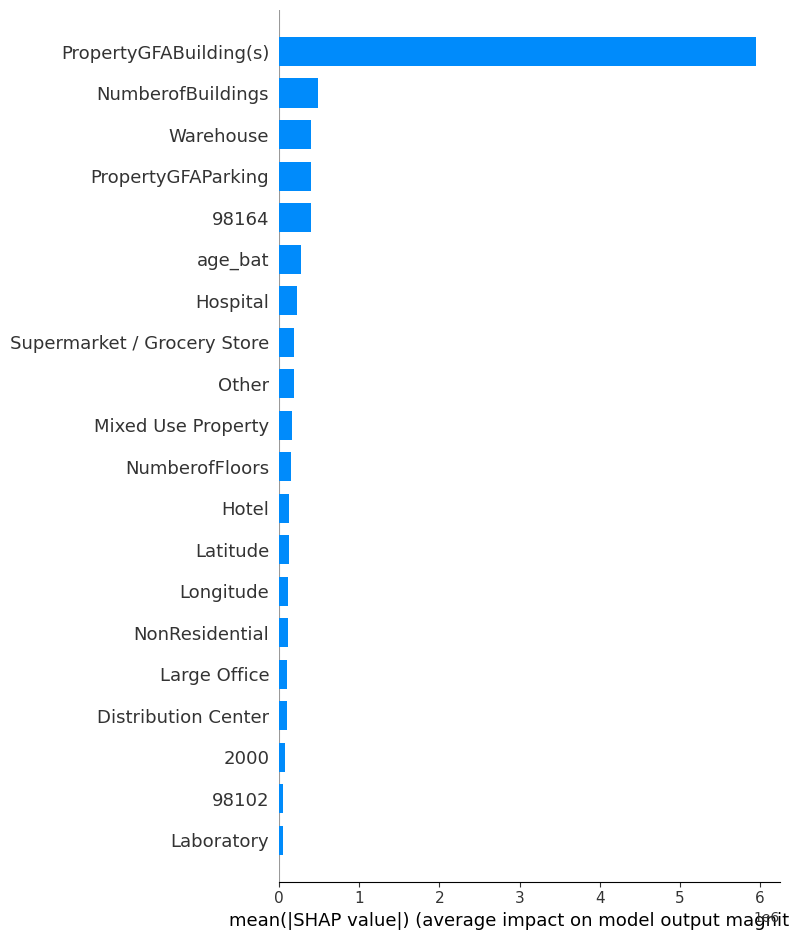

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


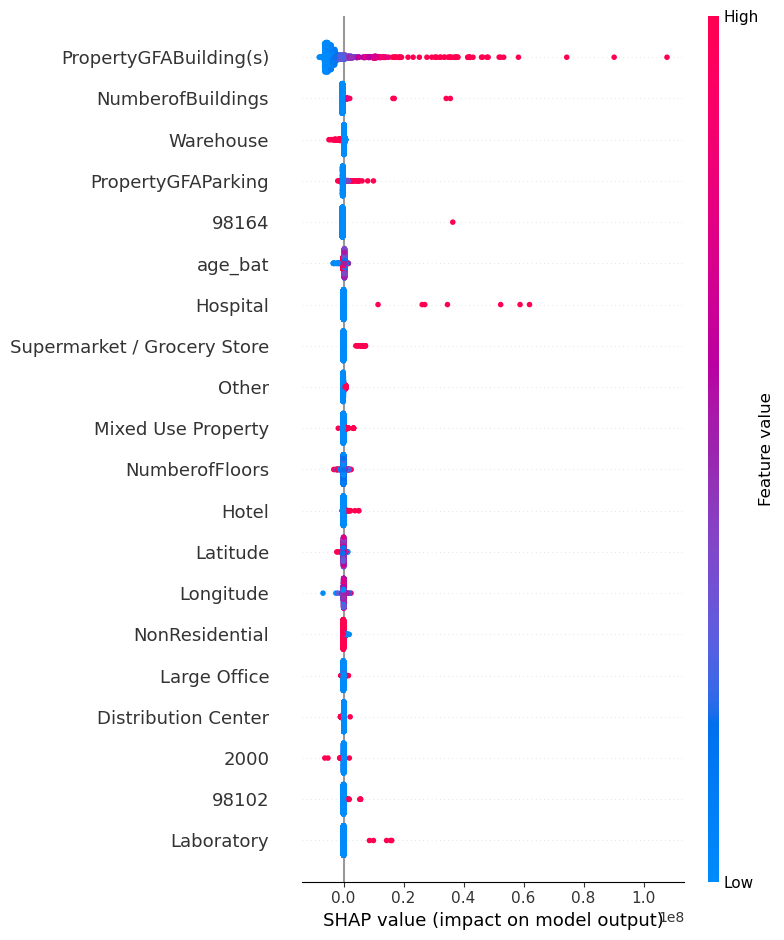




=========== [Importance globale des features pour TotalGHGEmissions] ===========


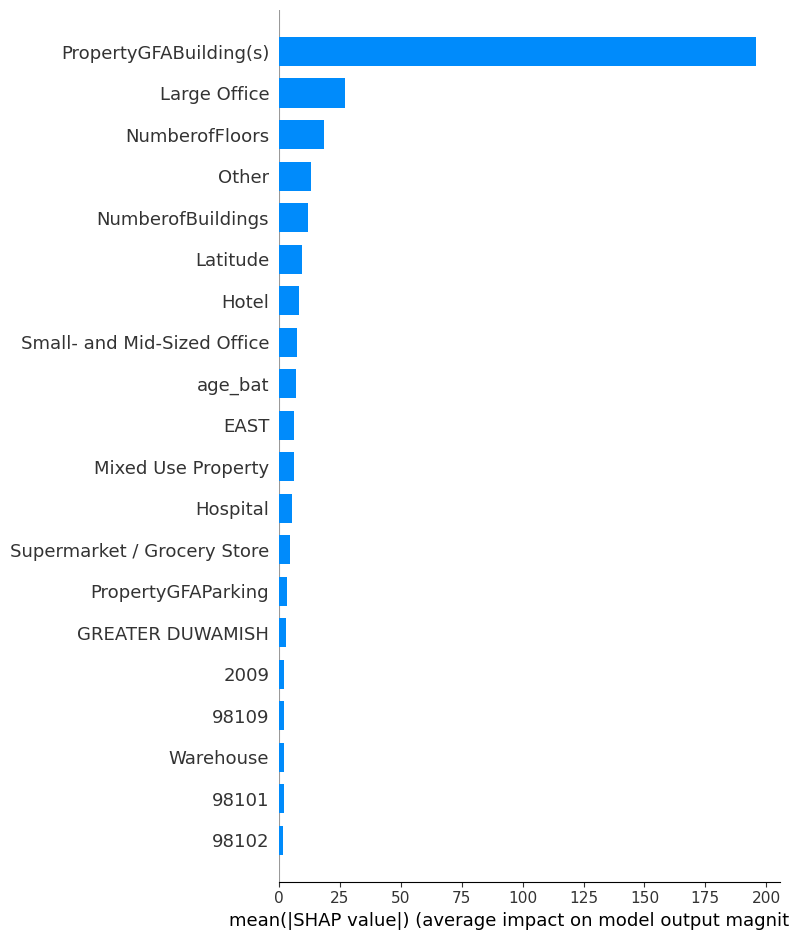

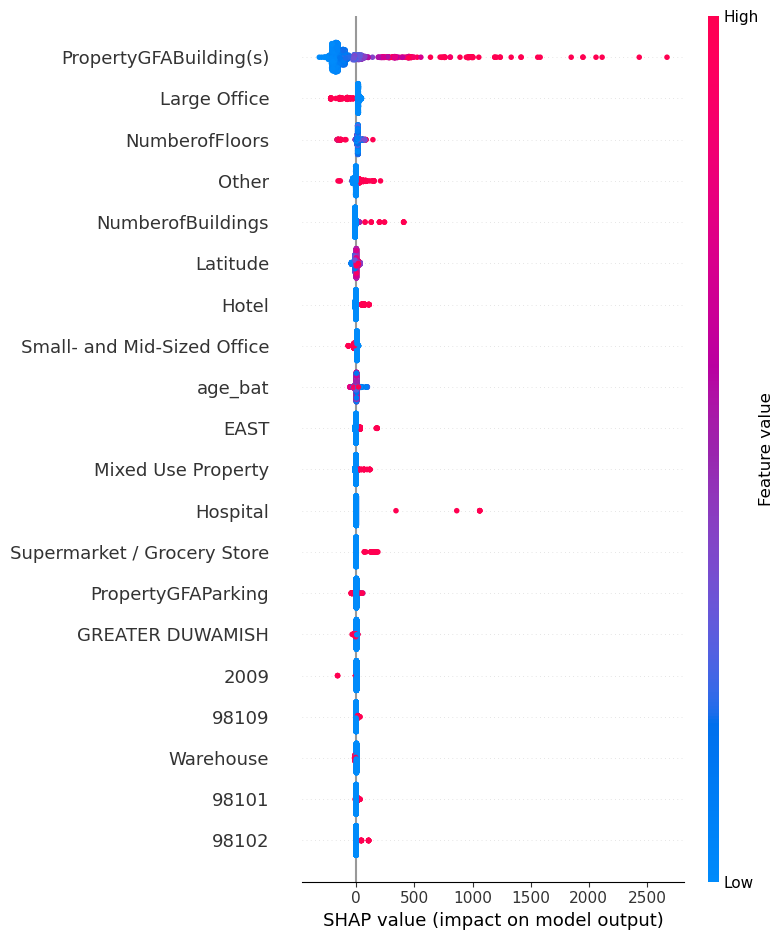

In [8]:
for i in [EnergyUse, 'TotalGHGEmissions'] :

    print(f"=========== [Importance globale des features pour {i}] ===========")

    # Je récupère le meilleur modèle du gridsearch (celui entraîné avec les meilleurs paramètres)
    globals()[f"best_model_{i}"] = globals()[f"grid_{i}"].best_estimator_

    # Création de l'explainer
    globals()[f"xgb_explainer_grid_{i}"] = shap.TreeExplainer(
        globals()[f"best_model_{i}"], X_train, feature_names=all_features
    )

    # Optention des valeurs de Shapley
    globals()[f"shap_values_{i}"] = globals()[f"xgb_explainer_grid_{i}"].shap_values(X_train, y_train)

    # Graphique représentant l'importance des features au global
    shap.summary_plot(
        globals()[f"shap_values_{i}"], X_train, feature_names=all_features, plot_type="bar"
    )


    shap.summary_plot(globals()[f"shap_values_{i}"], X_train, feature_names=all_features);

    # X_train_names = pd.DataFrame(X_train, columns=all_features)
    # shap.dependence_plot("PropertyGFABuilding(s)", shap_values_SiteEnergyUseWN_kBtu, X_train_names, interaction_index='auto')

    print("\n\n")


L'axe vertical gauche indique les noms des features, classées par ordre d'importance de haut en bas.<br>
L'axe horizontal représente l'ampleur des valeurs SHAP pour les prédictions.<br>
L'axe vertical droit représente l'ampleur réelle d'une features telle qu'elle apparaît dans l'ensemble de données et colore les points.<br>

## **Importance Locale des features avec SHAP**

Nous recalculons d'abord les valeurs Shap en utilisant l'objet Explainer. Cela diffère de la fonction shap_values, car cette fois, les valeurs Shap sont renvoyées avec quelques propriétés supplémentaires dont nous avons besoin pour l'interprétabilité locale.

=========== [Importance globale des features pour SiteEnergyUseWN_kBtu (instance n°1)] ===========


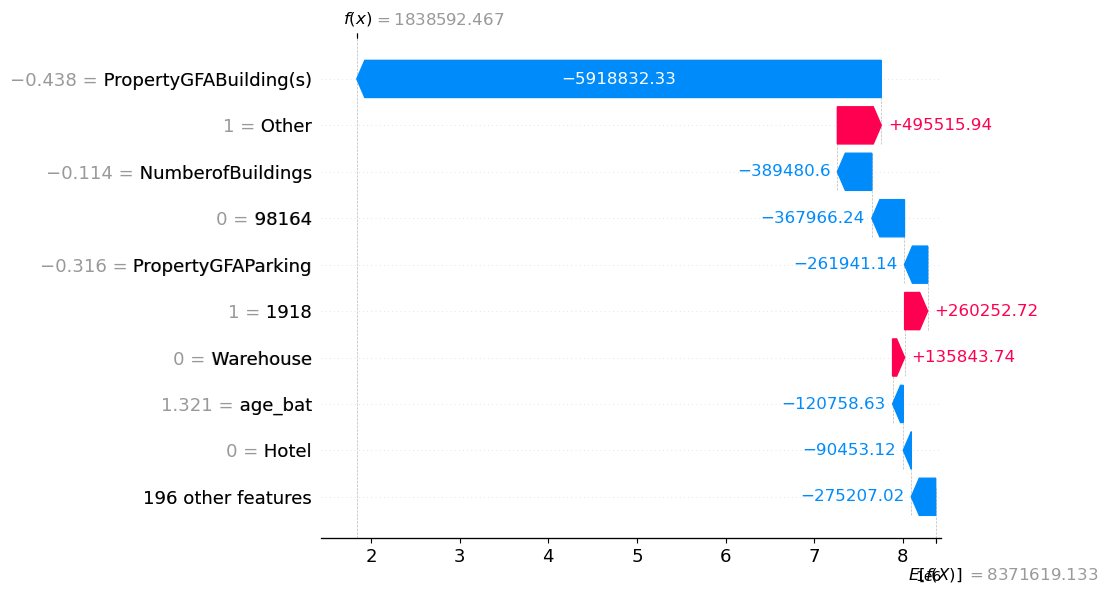

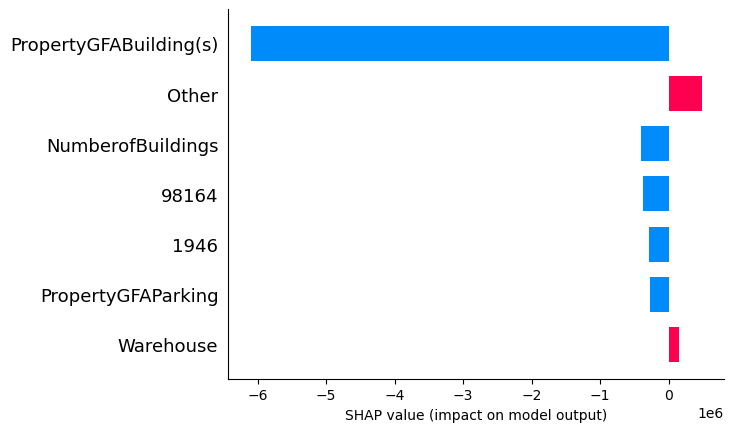

=========== [Importance globale des features pour TotalGHGEmissions (instance n°1)] ===========


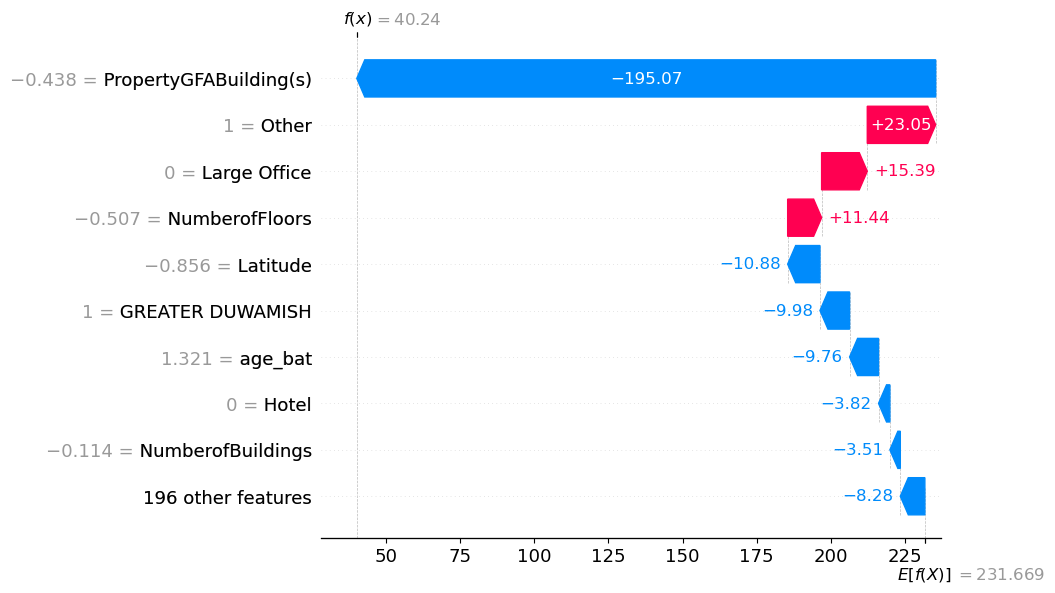

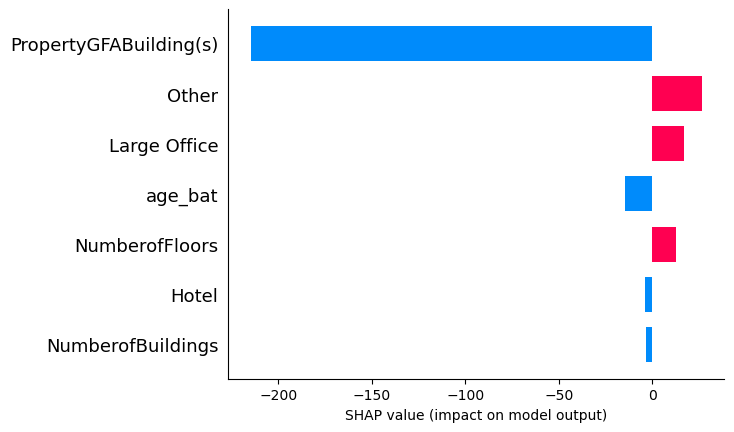

In [9]:
instance_a_tester = 0



for i in [EnergyUse, 'TotalGHGEmissions'] :

    print(f"=========== [Importance globale des features pour {i} (instance n°{instance_a_tester+1})] ===========")

    # On recalcule les shap values
    shap_explainer_values = globals()[f"xgb_explainer_grid_{i}"](X_train, y_train)

    shap.waterfall_plot(shap_explainer_values[instance_a_tester])

    shap.bar_plot(globals()[f"xgb_explainer_grid_{i}"].shap_values(X_test[0]),
                feature_names=all_features)
    

In [10]:
# ne s'affiche pas si inclu dans une boucle
shap.force_plot(shap_explainer_values[instance_a_tester])